In [1]:
%matplotlib inline
import utils_ted
from utils_ted import *

Using TensorFlow backend.


In [2]:
#path = "data/ml-20m/"
#path = "data/ml-small/"
path = "data/ml-1m/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [3]:
ratings = pd.read_csv(path+'ratings.dat', delimiter="::", header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
ratings.head()

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
len(ratings)

1000209

Just for display purposes, let's read in the movie names too.

In [5]:
movies = pd.read_csv(path+'movies.dat', delimiter="::", header=None, names=['MovieID','Title', 'Genres'])
movies.head()

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movie_names = movies.set_index('MovieID')['Title'].to_dict()

In [147]:
movie_names

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (1995)',
 33: 'Wings of Courage (1995)',
 34: 'Babe (1

In [7]:
users = ratings.UserID.unique()
movies = ratings.MovieID.unique()

In [145]:
movies[:10]

array([1193,  661,  914, 3408, 2355, 1197, 1287, 2804,  594,  919], dtype=int64)

In [8]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [9]:
ratings.UserID = ratings.UserID.apply(lambda x: userid2idx[x])
ratings.MovieID = ratings.MovieID.apply(lambda x: movieid2idx[x])

In [10]:
user_min, user_max, movie_min, movie_max = (ratings.UserID.min(), ratings.UserID.max(), ratings.MovieID.min(), ratings.MovieID.max())
user_min, user_max, movie_min, movie_max

(0, 6039, 0, 3705)

In [11]:
n_users = ratings.UserID.nunique()
n_movies = ratings.MovieID.nunique()
n_users, n_movies

(6040, 3706)

This is the number of latent factors in each embedding.

In [12]:
n_factors = 50

In [13]:
np.random.seed = 42

Randomly split into training and validation.

In [14]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [15]:
g = ratings.groupby("UserID")["Rating"].count()
topUsers = g.sort_values(ascending=False)[:15]

In [16]:
g = ratings.groupby("MovieID")["Rating"].count()
topMovies = g.sort_values(ascending=False)[:15]

In [17]:
top_r_u = ratings.join(topUsers, on="UserID", how='inner', rsuffix='_r')
top_r_u.head()

,UserID,MovieID,Rating,Timestamp,Rating_r
137560,888,2065,3,975261771,1518
137561,888,218,4,975253888,1518
137562,888,1231,4,975248201,1518
137563,888,2624,3,975261453,1518
137564,888,1232,3,975248230,1518


In [18]:
top_r = top_r_u.join(topMovies, on="MovieID", how='inner', rsuffix='_r')
top_r.head()

,UserID,MovieID,Rating,Timestamp,Rating_r,Rating_r
137595,888,97,5,975248256,1518,2649
157613,1014,97,5,975035522,1286,2649
184718,1149,97,2,975196851,1302,2649
190209,1180,97,5,974857870,1521,2649
239523,1448,97,2,974757533,1243,2649


In [19]:
pd.crosstab(index=top_r.UserID, columns=top_r.MovieID, values=top_r.Rating, aggfunc=np.sum)

MovieID,22,38,44,48,51,64,92,97,104,113,124,127,128,132,189
UserID,,,,,,,,,,,,,,,
888,4.0,NaN,4.0,3.0,4.0,3.0,4.0,5.0,2.0,3.0,4.0,NaN,5.0,5.0,3.0
1014,4.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0
1149,2.0,2.0,5.0,2.0,5.0,3.0,2.0,2.0,4.0,NaN,4.0,2.0,3.0,1.0,2.0
1180,3.0,4.0,4.0,4.0,3.0,3.0,3.0,5.0,3.0,2.0,4.0,3.0,3.0,5.0,4.0
1448,2.0,4.0,3.0,3.0,5.0,2.0,3.0,2.0,4.0,2.0,3.0,4.0,5.0,4.0,4.0
1679,3.0,5.0,2.0,5.0,5.0,3.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,4.0
1940,5.0,5.0,5.0,5.0,4.0,5.0,5.0,3.0,1.0,5.0,5.0,5.0,5.0,3.0,5.0
1979,5.0,5.0,4.0,5.0,5.0,4.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0
2062,4.0,4.0,4.0,2.0,2.0,4.0,5.0,2.0,5.0,4.0,4.0,4.0,5.0,5.0,3.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [27]:
batch_size = 64

In [20]:
user_in = Input(shape=(1, ), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1, ), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(movie_in)

In [23]:
user_in.shape

TensorShape([Dimension(None), Dimension(1)])

In [57]:
from keras.layers import merge
from keras.layers import dot, add

In [50]:
#x = Dot()([u, m])
x = dot([u, m], axes=2)
#x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model(inputs=[user_in, movie_in], outputs=x)
model.compile(Adam(0.001), loss='mse')

In [51]:
model.fit([trn.UserID, trn.MovieID], trn.Rating, batch_size=batch_size, epochs=1, verbose=2,
         validation_data= ([val.UserID, val.MovieID], val.Rating))

Train on 800339 samples, validate on 199870 samples
Epoch 1/1
312s - loss: 3.5602 - val_loss: 3.3768


In [31]:
model.optimizer.lr = 0.01

In [ ]:
model.fit([trn.UserID, trn.MovieID], trn.Rating, batch_size=batch_size, epochs=3, verbose=2,
         validation_data= ([val.UserID, val.MovieID], val.Rating))

In [ ]:
model.optimizer.lr = 0.001

In [ ]:
model.fit([trn.UserID, trn.MovieID], trn.Rating, batch_size=batch_size, epochs=6, verbose=2,
         validation_data= ([val.UserID, val.MovieID], val.Rating))

The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [33]:
print(trn.UserID.shape[0])
print(trn.MovieID.shape[0])

800339
800339


In [53]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1, ), dtype='int64', name=name)
    return inpt, Embedding(n_in, n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [54]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [55]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x) 

In [56]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [62]:
x = dot([u, m], axes=2)
x = Flatten()(x)
x = add([x, ub])
x = add([x, mb])
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [63]:
model.fit([trn.UserID, trn.MovieID], trn.Rating, batch_size=batch_size, epochs=1, verbose=2,
         validation_data= ([val.UserID, val.MovieID], val.Rating))

Train on 800339 samples, validate on 199870 samples
Epoch 1/1
304s - loss: 3.8372 - val_loss: 2.3098


In [64]:
model.optimizer.lr = 0.01

In [65]:
model.fit([trn.UserID, trn.MovieID], trn.Rating, batch_size=batch_size, epochs=6, verbose=2,
         validation_data= ([val.UserID, val.MovieID], val.Rating))

Train on 800339 samples, validate on 199870 samples
Epoch 1/6
303s - loss: 1.8743 - val_loss: 1.4653
Epoch 2/6
293s - loss: 1.1337 - val_loss: 0.9128
Epoch 3/6
279s - loss: 0.8607 - val_loss: 0.8542
Epoch 4/6
3972s - loss: 0.8343 - val_loss: 0.8432
Epoch 5/6
276s - loss: 0.8263 - val_loss: 0.8383
Epoch 6/6
278s - loss: 0.8227 - val_loss: 0.8367


In [66]:
model.optimizer.lr = 0.001

In [67]:
model.fit([trn.UserID, trn.MovieID], trn.Rating, batch_size=batch_size, epochs=10, verbose=2,
         validation_data= ([val.UserID, val.MovieID], val.Rating))

Train on 800339 samples, validate on 199870 samples
Epoch 1/10
265s - loss: 0.8210 - val_loss: 0.8359
Epoch 2/10
273s - loss: 0.8199 - val_loss: 0.8351
Epoch 3/10
267s - loss: 0.8193 - val_loss: 0.8349
Epoch 4/10
266s - loss: 0.8189 - val_loss: 0.8346
Epoch 5/10
289s - loss: 0.8187 - val_loss: 0.8337
Epoch 6/10
270s - loss: 0.8184 - val_loss: 0.8340
Epoch 7/10
286s - loss: 0.8181 - val_loss: 0.8337
Epoch 8/10
267s - loss: 0.8181 - val_loss: 0.8340
Epoch 9/10
307s - loss: 0.8179 - val_loss: 0.8336
Epoch 10/10
335s - loss: 0.8179 - val_loss: 0.8339


In [68]:
model.fit([trn.UserID, trn.MovieID], trn.Rating, batch_size=batch_size, epochs=5, verbose=2,
         validation_data= ([val.UserID, val.MovieID], val.Rating))

Train on 800339 samples, validate on 199870 samples
Epoch 1/5
378s - loss: 0.8178 - val_loss: 0.8340
Epoch 2/5
394s - loss: 0.8177 - val_loss: 0.8337
Epoch 3/5
401s - loss: 0.8176 - val_loss: 0.8338
Epoch 4/5
370s - loss: 0.8176 - val_loss: 0.8339
Epoch 5/5
323s - loss: 0.8177 - val_loss: 0.8339


In [69]:
model.save_weights(model_path+'bias.h5')

In [70]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [71]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.31857824]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [117]:
g = ratings.groupby("MovieID")["Rating"].count()
print(len(g))
topMovies = g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)
print(len(topMovies))

3706
2000


First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [118]:
get_movie_bias = Model(inputs=movie_in, outputs=mb)
movie_bias = get_movie_bias.predict(topMovies)

In [119]:
movie_ratings = [(b[0], movie_names[movies[i]]) for i, b in zip(topMovies, movie_bias)]

In [120]:
movie_ratings[:5]

[(2.7147923, 'American Beauty (1999)'),
 (2.8626208, 'Star Wars: Episode IV - A New Hope (1977)'),
 (2.6871936, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (2.4256289, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (2.1215928, 'Jurassic Park (1993)')]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [121]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.075063005, 'Kazaam (1996)'),
 (0.023225814, 'Police Academy 6: City Under Siege (1989)'),
 (0.026646329, 'Battlefield Earth (2000)'),
 (0.08682695, 'Baby Geniuses (1999)'),
 (0.10552494, 'Aces: Iron Eagle III (1992)'),
 (0.12584646, 'Stop! Or My Mom Will Shoot (1992)'),
 (0.15698791, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.22032197, 'Flintstones in Viva Rock Vegas, The (2000)'),
 (0.24990319, 'Poltergeist III (1988)'),
 (0.25095066, 'Home Alone 3 (1997)'),
 (0.27516526, 'Jaws 3-D (1983)'),
 (0.28929088, 'Exorcist II: The Heretic (1977)'),
 (0.30555987, 'Iron Eagle II (1988)'),
 (0.31314483, 'Speed 2: Cruise Control (1997)'),
 (0.31744969, 'She-Devil (1989)')]

In [122]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(3.0490553, 'Shawshank Redemption, The (1994)'),
 (3.034353,
  'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)'),
 (3.0307846, 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)'),
 (3.0218751, 'Paths of Glory (1957)'),
 (3.0047565, 'Third Man, The (1949)'),
 (2.9951458, 'Usual Suspects, The (1995)'),
 (2.9831753, 'Wrong Trousers, The (1993)'),
 (2.9598386, "Schindler's List (1993)"),
 (2.9472718, 'Godfather, The (1972)'),
 (2.946665,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (2.9407392, '400 Blows, The (Les Quatre cents coups) (1959)'),
 (2.9310911, 'Close Shave, A (1995)'),
 (2.9234993, 'Rear Window (1954)'),
 (2.9227283, 'Double Indemnity (1944)'),
 (2.9189656, 'Yojimbo (1961)')]

We can now do the same thing for the embeddings.

In [126]:
get_movie_emb = Model(inputs=movie_in, outputs=m)
movie_emb = np.squeeze(get_movie_emb.predict(topMovies))

In [127]:
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [134]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [135]:
movie_pca.shape

(3, 2000)

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [136]:
fac0 = movie_pca[0]

In [137]:
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac0, topMovies)]

In [141]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.096830703, 'Rocky III (1982)'),
 (0.095791176, 'When Harry Met Sally... (1989)'),
 (0.094529271, 'E.T. the Extra-Terrestrial (1982)'),
 (0.083284691, 'Independence Day (ID4) (1996)'),
 (0.074797101, 'Titanic (1997)'),
 (0.073286831, 'Rumble in the Bronx (1995)'),
 (0.072951406, 'Sixth Sense, The (1999)'),
 (0.07215143, 'Apt Pupil (1998)'),
 (0.07057181, 'Jumanji (1995)'),
 (0.069356278, 'Golden Child, The (1986)')]

In [142]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.1027243, 'Usual Suspects, The (1995)'),
 (-0.086147077, 'Trainspotting (1996)'),
 (-0.085926995, 'Brighton Beach Memoirs (1986)'),
 (-0.085397646, 'Carrie (1976)'),
 (-0.084904686, 'Rushmore (1998)'),
 (-0.076963693, '2001: A Space Odyssey (1968)'),
 (-0.074500196, 'Spaceballs (1987)'),
 (-0.073220946, 'Babe (1995)'),
 (-0.072785132, 'American Beauty (1999)'),
 (-0.072148956, 'To Wong Foo, Thanks for Everything! Julie Newmar (1995)')]

The 2nd

In [143]:
fac1 = movie_pca[1]

In [144]:
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac1, topMovies)]

In [148]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.11495983, 'Forces of Nature (1999)'),
 (0.11182465, 'Independence Day (ID4) (1996)'),
 (0.10126501, 'Escape from the Planet of the Apes (1971)'),
 (0.098934218, 'Mission: Impossible (1996)'),
 (0.091057703, 'Lethal Weapon 3 (1992)'),
 (0.08979775, 'Steel Magnolias (1989)'),
 (0.085114516, 'Jurassic Park (1993)'),
 (0.0847155, 'Young Guns II (1990)'),
 (0.07987006, 'Doors, The (1991)'),
 (0.078878403, 'Rocky (1976)')]

The 3rd

In [149]:
fac2 = movie_pca[2]

In [150]:
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac2, topMovies)]

In [151]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.086704321, 'True Grit (1969)'),
 (0.075741172, 'Run Lola Run (Lola rennt) (1998)'),
 (0.07393384, 'Rob Roy (1995)'),
 (0.073650248, 'Being John Malkovich (1999)'),
 (0.072957218, 'Steamboat Willie (1940)'),
 (0.072407663, 'Truth About Cats & Dogs, The (1996)'),
 (0.071394078, 'True Lies (1994)'),
 (0.071107447, 'Magnolia (1999)'),
 (0.07051672, 'Tron (1982)'),
 (0.07000415, 'Pet Sematary II (1992)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [155]:
"""
from importlib import reload
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
#sys.setdefaultencoding('utf-8') # needless in python 3
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr
"""

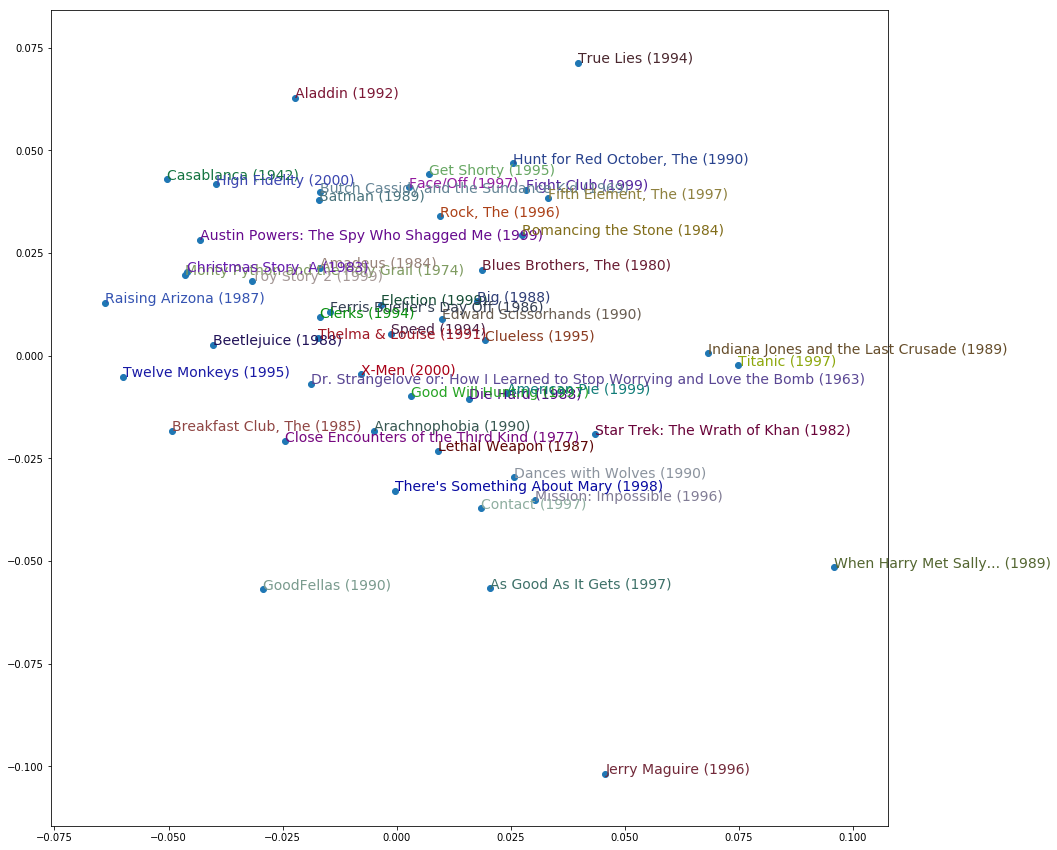

In [163]:
start=50; end=100
X=fac0[start:end]
Y=fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x, y, movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [164]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [165]:
from keras.layers import Concatenate
x = Concatenate()([u, m])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [167]:
nn.fit([trn.UserID, trn.MovieID], trn.Rating, batch_size=batch_size, epochs=8, verbose=2,
         validation_data= ([val.UserID, val.MovieID], val.Rating))

Train on 800339 samples, validate on 199870 samples
Epoch 1/8
315s - loss: 1.2998 - val_loss: 0.9290
Epoch 2/8
1467s - loss: 0.9678 - val_loss: 0.9258
Epoch 3/8
240s - loss: 0.9636 - val_loss: 0.9192
Epoch 4/8
257s - loss: 0.9602 - val_loss: 0.9145
Epoch 5/8
248s - loss: 0.9596 - val_loss: 0.9192
Epoch 6/8
286s - loss: 0.9580 - val_loss: 0.9157
Epoch 7/8
275s - loss: 0.9574 - val_loss: 0.9146
Epoch 8/8
279s - loss: 0.9570 - val_loss: 0.9104


This improves on our already impressive accuracy even further!